Full testing/ training of 

LinearRegression, KNeighborsRegressor, and keras CNN

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import find_peaks
from scipy import signal
from pathlib import Path
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import  RMSprop
import tensorflow as tf



/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Run this to get started
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')


dictionary_aurora_50_sampled_path = "measurements_auscultatory_dictionary_ALL.pkl"
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"
participants_data =  path_aurora_dataset / "participants.tsv"

# Use pwdb_model_configs file
#participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")




with open(dictionary_aurora_50_sampled_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]




keys_for_grouping = [
"Calibration_start",#0
"Static_challenge_start",#1
"Seated_calibration",#2
"Static_seated_challenge",#3
"Exercise_challenge_start",#4
"Temporal_challenge_start",#5
"Temporal_seated_challenge"]#6

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [7]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list,default=0) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # Butter filgter
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    # flatten pulse to X axis
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]

            # remove an angle the pulse is on
            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y



# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_by_hypertension(activity_number=1):
    participants_auroa_data = pd.read_csv(participants_data, sep = '\t')
    participants_csv_htn = participants_auroa_data[participants_auroa_data["self_report_htn"].isin(["managed","unmanaged"])]
    participants_csv_htn = participants_csv_htn[participants_csv_htn["pid"].str.contains('a')]
    people_htn = participants_csv_htn["pid"]

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        person_id = key.split("_")[1].split("/")[1]
        if not(person_id in list(people_htn)): 
            del title_filtered_all_auscultatory_dic[key]


    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    
    title_filtered_all_auscultatory_dic_2= dict(title_filtered_all_auscultatory_dic) 
    for key, each_grouping in title_filtered_all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic_2[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic_2.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,121), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# 671 people 
def filter_by_single_person(person_number):
    group_ppl = {}
    for key, each_grouping in list(all_auscultatory_dic.items()):
        person_id = key.split("_")[1].split("/")[1]
        if not(person_id in group_ppl):
            group_ppl[person_id] = []
        group_ppl[person_id].append(each_grouping)
    person1 = group_ppl[list(group_ppl.keys())[person_number]]
    auscultatory_pressure =[item[0] for item in person1]
    auscultatory_sbp = [item[1] for item in person1]
    auscultatory_dbp = [item[2] for item in person1]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]
# ===============================================================================================================================================================================


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50, pid=0):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    elif bp_variable=="single_person_s":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_sbp
    elif bp_variable=="single_person_d":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50, pid=0):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    elif bp_variable=="single_person_s":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_sbp
    elif bp_variable=="single_person_d":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50, pid=0):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    elif bp_variable=="single_person_s":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_sbp
    elif bp_variable=="single_person_d":
        if pid>671 or pid<0:
            return "This is not a person"
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp  = filter_by_single_person(pid)
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            # model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            # model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( bp_variable = "c", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        

In [3]:
# K-means funtctions 

# This prints all the pulses in a cluster
def plot_auscultatory_clusters(activity_number=0, n_clusters=1):
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)

    kmeans = KMeans(n_clusters=n_clusters)

    y = kmeans.fit_predict(auscultatory_pressure_real)
    for j in range(n_clusters):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [auscultatory_dbp_real[i].item() for i in indexes]
        sbp_variation = [auscultatory_sbp_real[i].item() for i in indexes]
        the_sbp = (round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))

        the_dbp = (round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        for i in indexes:
            plt.plot(auscultatory_pressure_real[i], color="#ED2B2A", )


        plt.title(
            f"SBP: {the_sbp[0]} ± {the_sbp[1]}\nDBP:{the_dbp[0]} ± {the_dbp[1]}",
    fontsize = 30
        )
        plt.xticks([])
        plt.yticks([])
        plt.show()




# I want to show as you add a pulse the avegera SD error goes down
def plot_clusters_bp_range(activity_number=0, data_type = "s"):
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    all_kmeans_sd =[]
    all_kmeans_mean =[]
    all_kmeans_numbers = []
    for k in range(1, 200):
        kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
        y = kmeans.fit_predict(auscultatory_pressure_real)
        list_kmean_sd =[]
        list_kmean_mean =[]
        list_kmean_nums =[]
        for j in range(k):
            indexes = [idx for idx, val in enumerate(y) if val == j]
            dbp_variation = [auscultatory_dbp_real[i].item() for i in indexes]
            sbp_variation = [auscultatory_sbp_real[i].item() for i in indexes]
            bp_variation=None
            if data_type =="s":
                bp_variation = sbp_variation
            else:
                bp_variation = dbp_variation
            list_kmean_mean.append(round(get_stats(dbp_variation)[3],1) )
            list_kmean_sd.append(round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
            list_kmean_nums.append(len(indexes))
        all_kmeans_sd.append(sum(list_kmean_sd) / len(list_kmean_sd))
        all_kmeans_mean.append(sum(list_kmean_mean) / len(list_kmean_mean))
        all_kmeans_numbers.append(sum(list_kmean_nums) / len(list_kmean_nums))

    plt.figure()
    plt.plot(list(range(len(all_kmeans_mean))), list(all_kmeans_sd),color= "#070A52")
    index_5 = all_kmeans_sd.index([i for i in all_kmeans_sd if i <= 5][0])
    plt.axhline(y=5, color='r', linestyle='-')
    plt.axvline(x=index_5, color='r', linestyle='-')

    plt.xlabel("Number of cluster")
    plt.ylabel(f"Mean of pulse {data_type}")
    plt.show()

    len(all_kmeans_sd)
    plt.figure()
    plt.plot(list(range(len(all_kmeans_numbers))), list(all_kmeans_numbers),linewidth=3,color= "#070A52")
    plt.xlabel("Number of cluster")
    plt.ylabel("Average size of cluser")
    plt.axvline(x=index_5, color='r', linestyle='-')


    plt.show()
    return index_5

# Gets you the number of clusters that meets the condition of under mmHg
def get_clusters_at5(activity_number=0, data_type = "s"):
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    all_kmeans_sd =[]
    all_kmeans_mean =[]
    all_kmeans_numbers = []
    for k in range(1, 200):

        kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
        y = kmeans.fit_predict(auscultatory_pressure_real)
        list_kmean_sd =[]
        list_kmean_mean =[]
        list_kmean_nums =[]
        for j in range(k):
            indexes = [idx for idx, val in enumerate(y) if val == j]
            dbp_variation = [auscultatory_dbp_real[i].item() for i in indexes]
            sbp_variation = [auscultatory_sbp_real[i].item() for i in indexes]
            bp_variation=None
            if data_type =="s":
                bp_variation = sbp_variation
            else:
                bp_variation = dbp_variation
            list_kmean_mean.append(round(get_stats(dbp_variation)[3],1) )
            list_kmean_sd.append(round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
            list_kmean_nums.append(len(indexes))
        all_kmeans_sd.append(sum(list_kmean_sd) / len(list_kmean_sd))
        if sum(list_kmean_sd) / len(list_kmean_sd)  <= 5:
            return len(all_kmeans_sd)

    #index_5 = all_kmeans_sd.index([i for i in all_kmeans_sd if i <= 5][0])
    
    return 0

# This clusters auscultatory data by iteratively using KNN to see if doing KKN with in cluster is better
def KNN_clusters(activity_number=0, data_type = "s"):

    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    whole_cluter_mea = []

    for i in range (1,get_clusters_at5(activity_number ,data_type),1):
        n_clusters=i
        kmeans = KMeans(n_clusters=n_clusters)

        y = kmeans.fit_predict(auscultatory_pressure_real)

        cluster_all = []
        for j in range(n_clusters):
            indexes = [idx for idx, val in enumerate(y) if val == j]
            dbp_variation = [auscultatory_dbp_real[i].item() for i in indexes]
            sbp_variation = [auscultatory_sbp_real[i].item() for i in indexes]
            bp_variation=None
            if data_type =="s":
                bp_variation = sbp_variation
            else:
                bp_variation = dbp_variation
            pulse_variation =   [auscultatory_pressure_real[i] for i in indexes ]
            cross_valid_space = int(len(pulse_variation)*(0.1))
            if len(pulse_variation)>15 :
                all_mea = []
                for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                    X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                    Y = np.array(bp_variation[0:i] +bp_variation[i+cross_valid_space:len(bp_variation)])
                    
                    X_other = pulse_variation[i:i+cross_valid_space] 
                    Y_other = np.array(bp_variation[i:i+cross_valid_space])
                    
                    X_train= np.array(X)
                    Y_train= np.array(Y)

                    X_test= np.array(X_other)
                    Y_test= np.array(Y_other)

                    

                    X_test = X_test.reshape(X_test.shape[0], -1)
                    Y_test = Y_test.reshape(Y_test.shape[0], -1)

                    #model = LinearRegression()
                    model = KNeighborsRegressor(n_neighbors=5)

                    X_test = X_test.reshape(X_test.shape[0], -1)

                    the_fit = model.fit(X_train, Y_train)

                    y_predict= model.predict(X_test)
                    

                    all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
                if len(all_mea)>0:
                    cluster_all.append(get_stats(all_mea)[3])
        if len(cluster_all)>0:
            #print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
            whole_cluter_mea.append(round(get_stats(cluster_all)[3], 2))
        
    return whole_cluter_mea

# This clusters auscultatory data by iteratively using Linear Regression to see if doing KKN with in cluster is better
def LinearRegression_clusters(activity_number=0, data_type = "s"):

    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    whole_cluter_mea = []

    for i in range (1,get_clusters_at5(activity_number ,data_type),1):
        n_clusters=i
        kmeans = KMeans(n_clusters=n_clusters)

        y = kmeans.fit_predict(auscultatory_pressure_real)

        cluster_all = []
        for j in range(n_clusters):
            indexes = [idx for idx, val in enumerate(y) if val == j]
            dbp_variation = [auscultatory_dbp_real[i].item() for i in indexes]
            sbp_variation = [auscultatory_sbp_real[i].item() for i in indexes]
            bp_variation=None
            if data_type =="s":
                bp_variation = sbp_variation
            else:
                bp_variation = dbp_variation
            pulse_variation =   [auscultatory_pressure_real[i] for i in indexes ]
            cross_valid_space = int(len(pulse_variation)*(0.1))
            if len(pulse_variation)>15 :
                all_mea = []
                for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                    X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                    Y = np.array(bp_variation[0:i] +bp_variation[i+cross_valid_space:len(bp_variation)])
                    
                    X_other = pulse_variation[i:i+cross_valid_space] 
                    Y_other = np.array(bp_variation[i:i+cross_valid_space])
                    
                    X_train= np.array(X)
                    Y_train= np.array(Y)

                    X_test= np.array(X_other)
                    Y_test= np.array(Y_other)

                    

                    X_test = X_test.reshape(X_test.shape[0], -1)
                    Y_test = Y_test.reshape(Y_test.shape[0], -1)

                    model = LinearRegression()

                    X_test = X_test.reshape(X_test.shape[0], -1)

                    the_fit = model.fit(X_train, Y_train)

                    y_predict= model.predict(X_test)
                    

                    all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
                if len(all_mea)>0:
                    cluster_all.append(get_stats(all_mea)[3])
        if len(cluster_all)>0:
            #print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
            whole_cluter_mea.append(round(get_stats(cluster_all)[3], 2))
        
    return whole_cluter_mea

# This plots the linear regression clustering testing s and d
def plot_Linear_comparison(activity_number=0 ):
    sbp_values = LinearRegression_clusters(activity_number,"s")
    dbp_values = LinearRegression_clusters(activity_number,"d")
    plt.plot(sbp_values ,color="#070A52", label="Tonometer SBP")
    plt.plot(dbp_values, color  = "#D21312",label="Tonometer DBP")
    plt.axhline(y = sbp_values[sbp_values.index(min(sbp_values))])
    plt.axhline(y = dbp_values[dbp_values.index(min(dbp_values))])
    plt.legend(loc='best')
    plt.xlabel("Number of Clusters")
    plt.ylabel("MEA")
    plt.title("Linear Regression Testing within Cluster Groups")
    plt.show()

# This plots the knn clustering testing s and d

def plot_KNN_comparison(activity_number=0 ):
    sbp_values = KNN_clusters(activity_number,"s")
    dbp_values = KNN_clusters(activity_number,"d")
    plt.plot(sbp_values ,color="#070A52", label="Tonometer SBP")
    plt.plot(dbp_values, color  = "#D21312",label="Tonometer DBP")
    plt.axhline(y = sbp_values[sbp_values.index(min(sbp_values))])
    plt.axhline(y = dbp_values[dbp_values.index(min(dbp_values))])
    plt.legend(loc='best')
    plt.xlabel("Number of Clusters")
    plt.ylabel("MEA")
    plt.title("KNN Testing within Cluster Groups")
    plt.show()

# plot simulated pulses
def plot_simulated_clusters( n_clusters=1):
    auscultatory_pressure_simulated, auscultatory_dbp_simulated = filter_charlton_subjects()
    kmeans = KMeans(n_clusters=n_clusters)

    y = kmeans.fit_predict(auscultatory_pressure_simulated)

    #print(y)
    for j in range(n_clusters):
        indexes = [idx for idx, val in enumerate(y) if val == j]

        dps_variation = [i for j, i in enumerate(auscultatory_dbp_simulated) if j not in indexes]
        the_dbp= [round(get_stats(dps_variation)[3],1), round(get_stats(dps_variation)[4] - get_stats(dps_variation)[3],1) ]
        for i in indexes:
            plt.plot(auscultatory_pressure_simulated[i], color= "#070A52")
        #plt.title(f"With {len(indexes)} in the group")
        plt.xticks([])
        plt.title(
            f"DBP:{the_dbp[0]} ± {the_dbp[1]}",
    fontsize = 40
        )
        plt.yticks([])
        plt.show()

# Uses KNN on simulated data
def plot_KNN_simulated(activity_number=0, n_clusters=1):
    auscultatory_pressure_simulated, auscultatory_dbp_simulated = filter_charlton_subjects()
    whole_cluter_mea = []
    for i in range (1,50,5):
        n_clusters=i
        kmeans = KMeans(n_clusters=n_clusters)

        y = kmeans.fit_predict(auscultatory_pressure_simulated)

        #print(y)
        cluster_all = []
        for j in range(n_clusters):
            indexes = [idx for idx, val in enumerate(y) if val == j]
            dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_simulated)) if j in indexes]
            dbp_variation=list(dbp_variation)
            
            pulse_variation =   [auscultatory_pressure_simulated[i] for i in indexes ]

            
            #all_mea = []
            cross_valid_space = int(len(pulse_variation)*(0.1))
            if len(pulse_variation)>10 :
                all_mea = []
                for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                    X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                    Y = np.array(dbp_variation[0:i] +dbp_variation[i+cross_valid_space:len(dbp_variation)])
                    
                    X_other = pulse_variation[i:i+cross_valid_space] 
                    Y_other = np.array(dbp_variation[i:i+cross_valid_space])
                    
                    X_train= np.array(X)
                    Y_train= np.array(Y)

                    X_test= np.array(X_other)
                    Y_test= np.array(Y_other)

                    X_test = X_test.reshape(X_test.shape[0], -1)
                    Y_test = Y_test.reshape(Y_test.shape[0], -1)

                    model = KNeighborsRegressor(n_neighbors=2)

                    X_test = X_test.reshape(X_test.shape[0], -1)

                    the_fit = model.fit(X_train, Y_train)

                    y_predict= model.predict(X_test)
                    
                

                    all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
                if len(all_mea)>0:
                    cluster_all.append(get_stats(all_mea)[3])
        if len(cluster_all)>0:
            print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
            whole_cluter_mea.append(get_stats(cluster_all)[3])
    return whole_cluter_mea

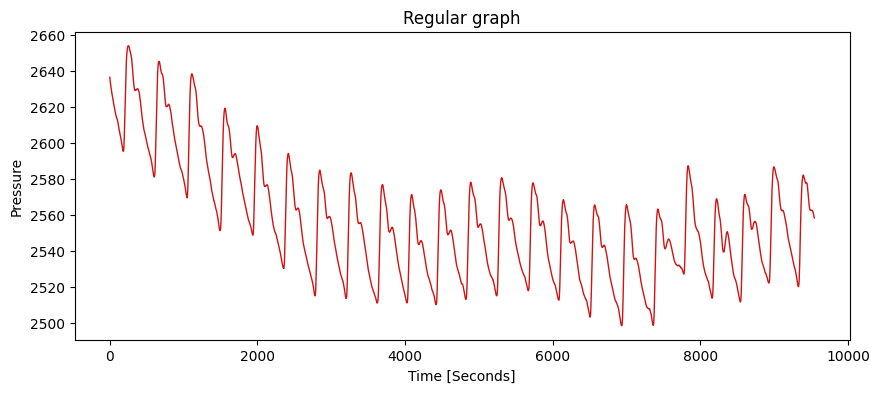

In [8]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "#D21312")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

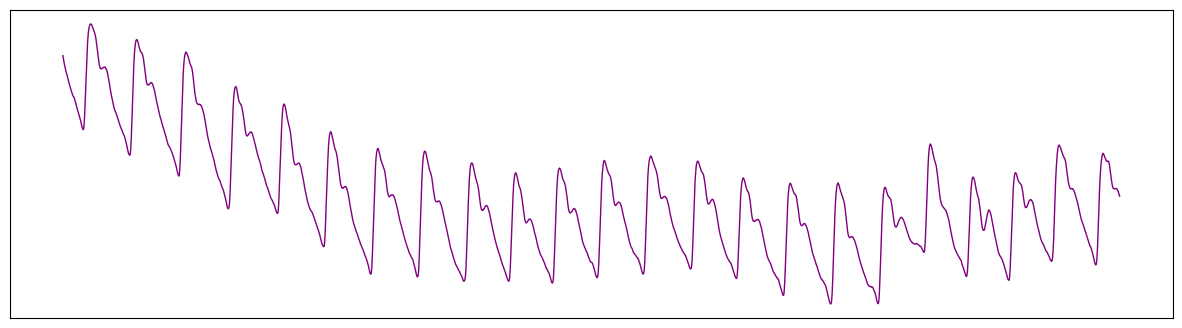

In [9]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

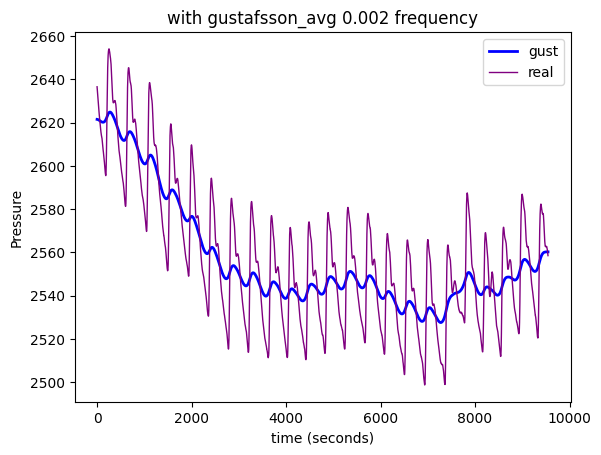

In [10]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

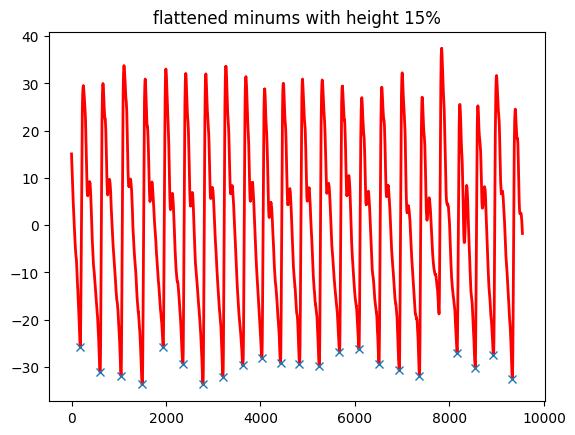

In [11]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [12]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

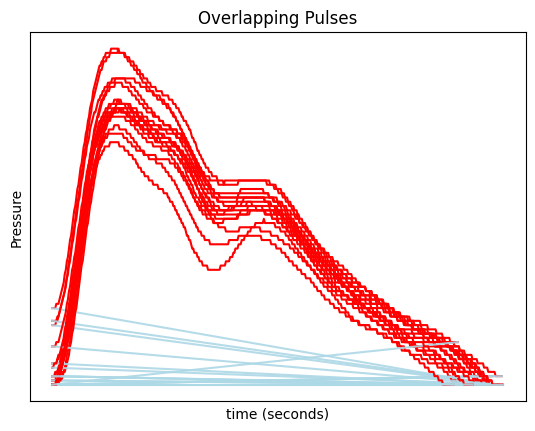

In [13]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="lightblue" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

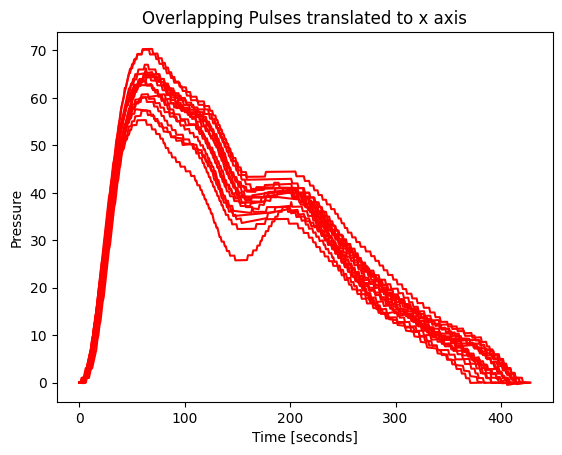

In [14]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

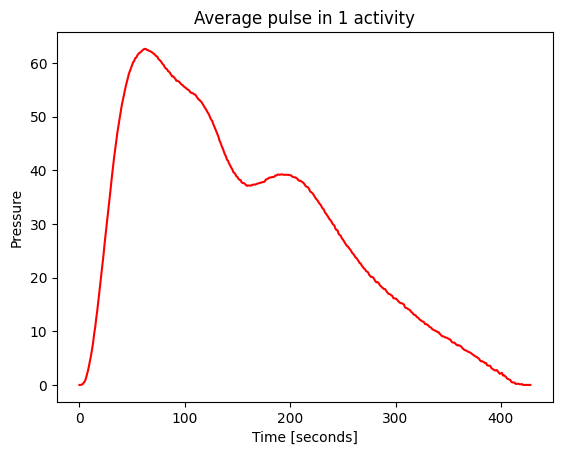

In [16]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


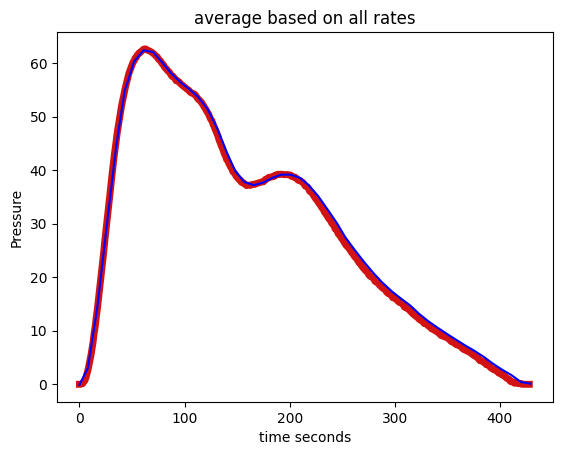

In [21]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(all_overlaps_means ,color= "#D21312", linewidth=5)
plt.plot(list(np.linspace(0, len(all_overlaps_means), 50, dtype=int)),resampled_y, "" ,color="blue" )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

In [727]:
# Models on all data with all activities + all people, aurora systolic with 50 index windows
# LinearRegression_MAE_cross(-1, "s",1000)
# KNN_MAE_cross(-1, "s",1000)
# CNN_MAE_cross(-1, "s",1000)

# Models no overlap in participants , 0=Calibration_start recordings, aurora systolic with 50 index windows
# LinearRegression_MAE_cross(0, "s",50)
# KNN_MAE_cross(0, "s",50)
# CNN_MAE_cross(0, "s",50)


# Model testing for 1 person, change PID
# KNN_MAE_cross(activity_number=0, bp_variable = "single_person_s", cross_valid_space = 1, pid=i)[0]
# LinearRegression_MAE_cross(activity_number=0, bp_variable = "c", cross_valid_space = 20)


# Running all models on activties
# all_activty_linear = {}
# all_activty_knn = {}
# all_activty_cnn = {}
# for i in range(0,7):
#     all_activty_linear[keys_for_grouping[i]] = LinearRegression_MAE_cross(i, "s",50)
#     all_activty_knn[keys_for_grouping[i]] = KNN_MAE_cross(i, "s",50)
#     all_activty_cnn[keys_for_grouping[i]] = CNN_MAE_cross(i, "d",50)


In [726]:
# Ploting MAE FOR ALL PPL
# plt.figure(figsize=(15, 10)) 

# plt.hist(data.values(),20, color ="#D21312")
# plt.axvline(x=5, color='black', linestyle='--', linewidth=5)
# plt.title("KNN person in person testing")
# plt.ylabel("Participants")
# plt.xlabel("MAE")

# plt.show() 

Epoch 1/50


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5308.1108 - mae: 72.4756 - val_loss: 2542.6257 - val_mae: 50.1659
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2060.8218 - mae: 43.5130 - val_loss: 301.9975 - val_mae: 14.3072
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 534.9497 - mae: 18.9751 - val_loss: 276.2270 - val_mae: 13.7311
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 486.7758 - mae: 17.8807 - val_loss: 199.4547 - val_mae: 12.2643
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 510.5986 - mae: 17.8964 - val_loss: 199.4275 - val_mae: 12.2301
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 536.9944 - mae: 19.0131 - val_loss: 196.7525 - val_mae: 12.1932
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.9037 - mae: 15.6768 - val_loss: 204.7164 - val_mae: 12.2682
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 481.3885 - mae: 17.1140 - val_loss: 249.5328 - val_mae: 13.0745
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

<Axes: >

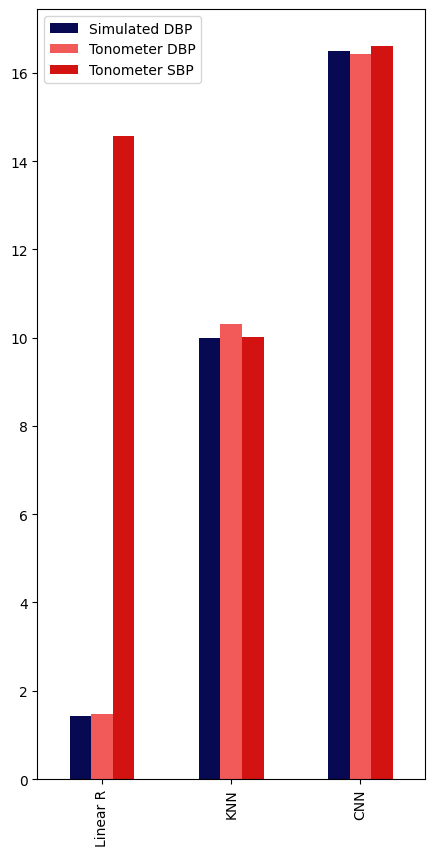

In [779]:
models_list = ("Linear Regression"," KNN","CNN")




# simulated_data = (6,1.7, 15.8)
# aura_dpb = (9.9, 10.3, 10.2)
# auroa_sbp = (16.5, 16.4, 16.3)

simulated_data = (LinearRegression_MAE_cross(-1, "c",50)[0], LinearRegression_MAE_cross(-1, "d",1000)[0],LinearRegression_MAE_cross(-1, "s",1000)[0])
aura_dpb = (KNN_MAE_cross(-1, "c",50)[0],KNN_MAE_cross(-1, "d",1000)[0],KNN_MAE_cross(-1, "s",1000)[0])
auroa_sbp = (CNN_MAE_cross_charlton("c",50)[0], CNN_MAE_cross(-1, "d",1000)[0], CNN_MAE_cross(-1, "s",1000)[0])

_data = {'Simulated DBP': simulated_data,
        'Tonometer DBP':aura_dpb,
        "Tonometer SBP":auroa_sbp}
_df = pd.DataFrame(_data,columns=list(_data), index = ['Linear R', 'KNN', 'CNN'])

_df.plot.bar(figsize=(5,5),color=[ "#070A52", "#F15A59","#D21312" ])
# plt.show()

Done with Auroa and Charlton

Now I want to makethe graph chart

In [119]:
all_models = {}

for i in range(len(keys_for_grouping)):
    all_models[keys_for_grouping[i]]= [LinearRegression_MAE_cross(i, "d",50)[0], LinearRegression_MAE_cross(i, "s",50)[0] ,
                                       KNN_MAE_cross(i, "d",50)[0] , KNN_MAE_cross(i, "s",50)[0] ,

                                       CNN_MAE_cross(i, "d",50)[0],CNN_MAE_cross(i, "s",50)[0],
                                       ]


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3812.9685 - mae: 52.3161 - val_loss: 2000.1405 - val_mae: 39.1704
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1888.0754 - mae: 36.6330 - val_loss: 1902.8728 - val_mae: 37.7747
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1887.2532 - mae: 34.6558 - val_loss: 1586.4385 - val_mae: 33.4857
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1601.3065 - mae: 33.2977 - val_loss: 2736.7085 - val_mae: 48.8733
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1739.5947 - mae: 35.8933 - val_loss: 2726.7202 - val_mae: 48.7491
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1697.1028 - mae: 34.1844 - val_loss: 2648.9329 - val_mae: 47.9061
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1635.5669 - mae: 34.0498 - val_loss: 2284.8958 - val_mae: 43.4870
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1783.2411 - mae: 35.1671 - val_loss: 1774.0676 - val_mae: 36.1187
Epoch 9/50
14/14 ━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3909.6370 - mae: 52.5421 - val_loss: 1948.3918 - val_mae: 38.2795
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2151.9541 - mae: 39.0283 - val_loss: 2844.8064 - val_mae: 49.5700
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1972.5522 - mae: 37.2348 - val_loss: 1822.3326 - val_mae: 36.6781
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1801.4442 - mae: 34.6653 - val_loss: 2720.2466 - val_mae: 48.2351
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1663.9939 - mae: 34.2962 - val_loss: 2314.8032 - val_mae: 43.2542
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1961.5033 - mae: 35.9967 - val_loss: 2138.1079 - val_mae: 41.0318
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1642.8029 - mae: 33.7241 - val_loss: 3247.2661 - val_mae: 54.1769
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1717.9437 - mae: 34.4533 - val_loss: 3541.9004 - val_mae: 57.1466
Epoch 9/50
14/14 ━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3918.2913 - mae: 55.8633 - val_loss: 1746.7385 - val_mae: 35.0472
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1721.2251 - mae: 34.3559 - val_loss: 1702.4669 - val_mae: 34.3960
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1819.0813 - mae: 34.5982 - val_loss: 2059.0334 - val_mae: 40.1472
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1743.9011 - mae: 34.5274 - val_loss: 1691.3263 - val_mae: 34.4401
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1849.8485 - mae: 35.4147 - val_loss: 2057.3372 - val_mae: 40.2236
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1789.1196 - mae: 35.1972 - val_loss: 1933.4130 - val_mae: 38.5236
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1739.7201 - mae: 35.4750 - val_loss: 2048.0618 - val_mae: 40.1700
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1623.0480 - mae: 33.0958 - val_loss: 2065.4321 - val_mae: 40.4642
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3620.1902 - mae: 51.3725 - val_loss: 1533.7262 - val_mae: 32.2423
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2141.1450 - mae: 38.5457 - val_loss: 1978.6713 - val_mae: 39.1575
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1958.9589 - mae: 37.6090 - val_loss: 1682.4653 - val_mae: 34.9468
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2362.8323 - mae: 40.1273 - val_loss: 2385.7734 - val_mae: 44.5482
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1781.5763 - mae: 34.7405 - val_loss: 1502.2623 - val_mae: 31.8067
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2195.4927 - mae: 37.8426 - val_loss: 2030.7933 - val_mae: 40.1076
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1835.1730 - mae: 34.4916 - val_loss: 2767.6250 - val_mae: 49.1588
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1910.8281 - mae: 36.9489 - val_loss: 2565.5652 - val_mae: 46.8635
Epoch 9/50
10/10 ━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3123.8152 - mae: 47.6120 - val_loss: 1970.9199 - val_mae: 37.1294
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1605.3252 - mae: 32.7098 - val_loss: 2001.1101 - val_mae: 38.3043
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1656.5868 - mae: 33.3794 - val_loss: 1965.4299 - val_mae: 36.5163
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1736.8843 - mae: 34.8132 - val_loss: 2102.8328 - val_mae: 39.9998
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1626.7909 - mae: 33.8958 - val_loss: 1966.7949 - val_mae: 37.5409
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1516.3823 - mae: 31.8516 - val_loss: 1988.5641 - val_mae: 38.2458
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1689.6534 - mae: 33.8160 - val_loss: 1940.9130 - val_mae: 37.1965
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1587.9082 - mae: 32.9464 - val_loss: 2147.4346 - val_mae: 40.7729
Epoch 9/50
14/14 ━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2712.8799 - mae: 45.0174 - val_loss: 2170.1816 - val_mae: 41.6430
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1690.3245 - mae: 33.9550 - val_loss: 2174.7681 - val_mae: 41.7761
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1482.7798 - mae: 31.8046 - val_loss: 2224.7957 - val_mae: 42.4262
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1518.5127 - mae: 32.6786 - val_loss: 2124.3755 - val_mae: 41.1752
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1561.7825 - mae: 32.6051 - val_loss: 2169.3374 - val_mae: 41.7986
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1429.1027 - mae: 31.1869 - val_loss: 2089.1646 - val_mae: 40.8549
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1551.2078 - mae: 32.2068 - val_loss: 2395.3599 - val_mae: 44.6548
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1547.6503 - mae: 32.7948 - val_loss: 2095.4495 - val_mae: 41.0174
Epoch 9/50
14/14 ━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3666.3828 - mae: 54.8845 - val_loss: 2194.4241 - val_mae: 36.4142
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1929.0585 - mae: 35.3870 - val_loss: 2314.1606 - val_mae: 43.3689
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1863.8705 - mae: 37.2758 - val_loss: 2213.8459 - val_mae: 41.7365
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1588.8959 - mae: 34.6238 - val_loss: 2854.3801 - val_mae: 50.2540
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1793.9087 - mae: 36.4887 - val_loss: 2122.5310 - val_mae: 40.3152
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1536.4579 - mae: 31.5820 - val_loss: 2480.7944 - val_mae: 46.0522
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1575.9866 - mae: 33.5429 - val_loss: 2253.5264 - val_mae: 42.8633
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1574.6252 - mae: 33.0310 - val_loss: 2460.7898 - val_mae: 45.8852
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━

In [469]:
all_models ={'Calibration_start': [9.784285714285716,
  14.330714285714285,
  9.727142857142857,
  14.381428571428573,
  18.073241029466903,
  24.440193244389125],
 'Static_challenge_start': [9.980714285714287,
  14.60142857142857,
  9.824285714285717,
  14.715,
  17.157929624829972,
  24.31985248838152],
 'Seated_calibration': [9.55888888888889,
  15.743333333333332,
  9.465555555555556,
  15.41111111111111,
  27.111482938130695,
  32.1517399681939],
 'Static_seated_challenge': [10.217,
  16.494999999999997,
  10.041,
  15.431999999999999,
  24.91015682220459,
  37.37902336120605],
 'Exercise_challenge_start': [16.393571428571427,
  25.395000000000003,
  13.963571428571429,
  22.301428571428573,
  18.11030946459089,
  29.599696976797922],
 'Temporal_challenge_start': [9.940000000000001,
  14.605714285714285,
  9.847142857142858,
  14.276428571428571,
  17.738566671098983,
  18.713539055415563],
 'Temporal_seated_challenge': [10.02,
  15.784444444444444,
  9.81111111111111,
  14.600000000000001,
  18.06199052598741,
  34.936531172858345]}

Showing clustering

In [24]:
get_clusters_at5(activity_number = 0,data_type = "d")

166

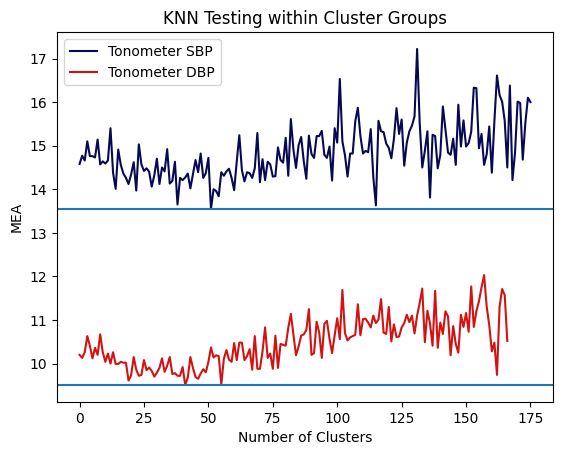

In [42]:
plot_KNN_comparison(0)